In [1]:
import pandas as pd 
import numpy as np
from scipy.sparse import *
import matplotlib.pyplot as plt
import seaborn as sns 
from sklearn.metrics.pairwise import linear_kernel #aka dot product
from tqdm import tqdm
from sklearn.model_selection import train_test_split
import string
from nltk.corpus import stopwords
stop = stopwords.words('english')
from nltk.tokenize import word_tokenize
from sklearn.pipeline import make_union
import re
np.random.seed(42)
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.utils.np_utils import to_categorical
from keras.layers import Dense, Input, Flatten, merge, LSTM, Lambda, Dropout
from keras.layers import Conv1D, MaxPooling1D, Embedding, Reshape
from keras.models import Model
from keras.optimizers import Adam
from keras.layers.wrappers import TimeDistributed, Bidirectional
from keras.layers.normalization import BatchNormalization
from keras import backend as K
from tqdm import tqdm
import sys
import gc
import scipy
import math
import random
import nltk
import string
import sklearn
from nltk.corpus import stopwords
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity

Using TensorFlow backend.


In [6]:
import os 
os.chdir('D:/Documents/Dataset/')

ratings = pd.read_csv('fulldf.csv', nrows=500000)
ratings.head()

,anime_id,watched_count,synopsis,year,name,genre,type,episodes,overall_rating,members,user_id,user_rating
0,1,15509.0,"In the year 2071, humanity has colonized sever...",1998.0,Cowboy Bebop,"Action, Adventure, Comedy, Drama, Sci-Fi, Space",TV,26.0,8.82,486824.0,13,8.82
1,1,15509.0,"In the year 2071, humanity has colonized sever...",1998.0,Cowboy Bebop,"Action, Adventure, Comedy, Drama, Sci-Fi, Space",TV,26.0,8.82,486824.0,19,10.00
2,1,15509.0,"In the year 2071, humanity has colonized sever...",1998.0,Cowboy Bebop,"Action, Adventure, Comedy, Drama, Sci-Fi, Space",TV,26.0,8.82,486824.0,21,9.00
3,1,15509.0,"In the year 2071, humanity has colonized sever...",1998.0,Cowboy Bebop,"Action, Adventure, Comedy, Drama, Sci-Fi, Space",TV,26.0,8.82,486824.0,23,9.00
4,1,15509.0,"In the year 2071, humanity has colonized sever...",1998.0,Cowboy Bebop,"Action, Adventure, Comedy, Drama, Sci-Fi, Space",TV,26.0,8.82,486824.0,32,10.00


In [7]:
ratings["nb_rating"] = ratings.groupby(["user_id"])["anime_id"].transform("size")
ratings = ratings.query('nb_rating > 8')

In [8]:
ratings.shape

(362843, 13)

# SKIPGRAM MODEL

In [9]:
import math
import tensorflow as tf

class SkipGramModel(object):

    """Word2Vec ( Mikolov et al.) using skipgram model. Can be used on non-word text
    inputs too!
    
    Attributes:
        b (tf.Variable): bias for nce loss
        batch_size (int): size of training batch
        embedding_dims (int): size of embedding
        embeddings (tf.Variable): embedding object for text/items
        init_op (tf.global_variables_initializer): this is tf.global_variables_initializer 
            to initilize variable in the model. call as model.init_op() in session.
        loss (TYPE): model loss function - mean NCE loss
        lr (TYPE): learning rate passed to optimizer 
        n_samples (int): number of negative samples based on batch size and
            the sample_factor parameter.
        normalized_embeddings (tensor): normalized embeddings
        optimize (tensor): optimization step
        optimizer (tf.train.Optimizer): optimizer default is adagrad
        saver (tf.train.Saver): tf.train.Saver object call in session after model.init_op().
        similarity (tensor): measure similarity on val_x
        val_data (np.array, 'int32'): indexes of validation samples to evaluate similarity on during training
        val_x (tf.Placeholder): from val_data
        vocab_size (int): size of 'vocabulary'
        w (tf.Variable): weights for nce loss
        x (tf.Placeholder): placeholder for input data
        y (tf.Placeholder): placeholder for input labels
    """
    
    def __init__(self, vocab_size, val_data, embedding_dims=256, batch_size=128, sample_factor=1, lr=1., optimizer=tf.train.AdagradOptimizer):
        
        self.embedding_dims = embedding_dims
        self.vocab_size = vocab_size
        self.batch_size = batch_size
        self.optimizer = optimizer
        self.val_data = val_data

        #number of negative samples (batch * sample factors)
        self.n_samples = int(round(sample_factor  * self.batch_size))
        self.lr = lr 
        self.init_model()
        
    @staticmethod
    def embed(embeddings, inp):
        return tf.nn.embedding_lookup(embeddings, inp)
    
    def mean_nce_loss(self, inp):
        return tf.reduce_mean(tf.nn.nce_loss(weights=self.w,
                                                 biases=self.b,
                                                 labels=self.y,
                                                 inputs=inp,
                                                 num_sampled=self.n_samples,
                                                 num_classes=self.vocab_size), name='loss')
    
    def normalize_embeddings(self):
        norm = tf.sqrt(tf.reduce_sum(tf.square(self.embeddings), 1, keep_dims=True))
        normalized_embeddings = self.embeddings / norm
        self.normalized_embeddings = normalized_embeddings
    
    def get_similarity(self, t):
        pred_embeddings = self.embed(self.normalized_embeddings, t)
        sim = tf.matmul(pred_embeddings, self.normalized_embeddings, transpose_b=True)
        return sim
    
    def init_model(self):
        # Input data.
        self.x = tf.placeholder(tf.int32, shape=[self.batch_size], name='x')
        self.y = tf.placeholder(tf.int32, shape=[self.batch_size, 1], name='y')
        self.val_x = tf.constant(self.val_data, name='val_x')
        # embedding var

        with tf.device('/cpu:0'):
            self.embeddings = tf.Variable(tf.random_uniform([self.vocab_size, self.embedding_dims], -1.0, 1.0))
            # nce loss weights and biases
            self.w = tf.Variable(tf.truncated_normal([self.vocab_size, self.embedding_dims],
                                                    stddev=1.0 / math.sqrt(self.embedding_dims)))
            self.b = tf.Variable(tf.zeros([self.vocab_size]))

        embedded = self.embed(self.embeddings, self.x)
        self.loss = self.mean_nce_loss(embedded)
        self.optimize = self.optimizer(self.lr).minimize(self.loss, name='optimize')

        self.normalize_embeddings()
        self.similarity = self.get_similarity(self.val_x)
        self.init_op = tf.global_variables_initializer
        self.saver = tf.train.Saver

counts =  interactions_full_df["anime_id"].value_counts()
"""
Remove anime that appear only once"""
ratings = interactions_full_df.loc[interactions_full_df.anime_id.isin(counts.loc[(counts > 1)].index)]
print("Users {} , Anime {}".format(ratings["user_id"].nunique(), ratings["anime_id"].nunique()))
ratings = pd.merge(anime[["name", "anime_id"]], ratings, left_on = "anime_id", right_on = "anime_id")
ratings.head()

In [10]:
"""we'll replace the anile id with an integer representing it's freqency and make a dictionary with the new id and the anime name.
"""
# make a dictionary of old_id2 moviename
id2anime_name = dict(ratings[['anime_id', 'name']].values)
# make a dictionary mapping of new id (based on frequency) and the anime_name
# by convention we'll let reserve 0 in case we want to use this for masking
# in the future...
id2idx = {k:i+1 for i, (k, v) in enumerate(ratings.anime_id.value_counts().items())}
# id2idxmake a dictionary of to new moviename
dictionary = {id2idx[k]: id2anime_name[k] for k in id2idx}
id2idx[0] = 'null'
dictionary[0] = 'null'
reverse_dictionary = {v:k for k,v in dictionary.items()}
ratings = ratings.loc[ratings.anime_id.isin(id2idx)]
ratings.anime_id = ratings.anime_id.apply(lambda x : id2idx[x])
# delete the id_2_movie_name & the movies frame we won't need them anymore
del id2anime_name
ratings.head()

,anime_id,watched_count,synopsis,year,name,genre,type,episodes,overall_rating,members,user_id,user_rating,nb_rating
0,4,15509.0,"In the year 2071, humanity has colonized sever...",1998.0,Cowboy Bebop,"Action, Adventure, Comedy, Drama, Sci-Fi, Space",TV,26.0,8.82,486824.0,13,8.82,11
2,4,15509.0,"In the year 2071, humanity has colonized sever...",1998.0,Cowboy Bebop,"Action, Adventure, Comedy, Drama, Sci-Fi, Space",TV,26.0,8.82,486824.0,21,9.00,11
6,4,15509.0,"In the year 2071, humanity has colonized sever...",1998.0,Cowboy Bebop,"Action, Adventure, Comedy, Drama, Sci-Fi, Space",TV,26.0,8.82,486824.0,43,10.00,11
8,4,15509.0,"In the year 2071, humanity has colonized sever...",1998.0,Cowboy Bebop,"Action, Adventure, Comedy, Drama, Sci-Fi, Space",TV,26.0,8.82,486824.0,50,10.00,11
9,4,15509.0,"In the year 2071, humanity has colonized sever...",1998.0,Cowboy Bebop,"Action, Adventure, Comedy, Drama, Sci-Fi, Space",TV,26.0,8.82,486824.0,51,10.00,21


In [11]:
"""I'll also define a really simple fuzzy lookup interface to the dictionary 
so that we can look up anime names without putting in year or being exact about their titles....
"""
import re
anime_series = pd.Series(dictionary)

def fuzzy_movie_lookup(anime_str, data=anime_series):
    """query a movie name using a regex string
    return all matches and their indexes.
    """
    return data.loc[data.str.contains(anime_str, flags=re.IGNORECASE)]

"""
We can sort each users movie choices by rating and then by timestamp 
so that when we generate values within a window the users positive and negative preferences will be reflected as well
as a bit about the order in which they watched them.
"""
data =[]
for key, chunk in ratings.groupby('user_id'):
    data.append(chunk.sort_values('user_rating').anime_id.values)

In [12]:
data[:10]

[array([39, 20,  2, 36, 13, 18, 73, 31, 78, 68, 80, 54, 62, 60, 64, 27, 52,
         3, 84, 29, 17, 35, 12, 63,  8], dtype=int64),
 array([73,  7, 51, 62, 33,  1, 35, 30, 10, 80,  2], dtype=int64),
 array([28,  2, 61, 15, 89, 14, 26,  7,  1, 32, 57,  6], dtype=int64),
 array([77, 88, 12,  8,  2, 14, 19, 10, 47,  6,  4], dtype=int64),
 array([24,  1,  8, 88, 14, 12,  2,  6, 47, 10], dtype=int64),
 array([54,  3, 33, 45, 35,  4, 19, 30,  6,  2, 10], dtype=int64),
 array([52, 84, 50,  3, 14, 27, 64, 69, 80, 32,  4], dtype=int64),
 array([25, 22,  1, 17, 46, 35, 80,  4, 47,  3, 26], dtype=int64),
 array([77, 52, 74, 45, 17, 19,  8,  2, 88, 67,  5,  9, 11,  6,  1,  4, 14,
        22, 47, 26, 29], dtype=int64),
 array([38, 36, 83, 85, 31, 42, 53, 58, 13, 23, 56, 65, 39, 72, 37, 74, 70,
        76,  7, 33, 66, 50, 54, 59, 64, 51, 49, 21,  5,  3, 45, 73, 24, 11,
        89, 84, 12, 48, 71,  9,  2,  1, 14, 19, 17, 80,  6,  4, 26],
       dtype=int64)]


#### generator
make a generator for data using each 'user' as a document.

In [14]:
import random

def get_batch(seq, rel_window_size=.2):
    """get a batch of data for a single user sequence.
    data will be chosen randomly from within a anime 
    window relative to the size of the entire sequence. 
    with the initial point chosen at random.
    """
    window = math.floor(len(seq) * rel_window_size) +1
    x = []
    y = []
    i = random.randint(0, len(seq)-1)
    for _ in range(batch_size):
        x.append(seq[i])
        moves = list(range(max(i-window, 0), i)) + list(range(i+1, min((i+window + 1, len(seq)))))
        j = random.choice(moves)
        y.append(seq[j])
        i = j
    return x, y            
            
def gen_batch(data, batch_size, rel_window_size=.2, shuffle=True):
    """make a generator for data using each 'user' as a document."""
    while True:
        for doc_index, doc in enumerate(data):
            x, y = get_batch(doc, rel_window_size)
            yield np.array(x, 'int32'), np.expand_dims(np.array(y,'int32'), 1)
        if shuffle:
            random.shuffle(data)

In [ ]:
"""
sample films to watch during training:¶
define a set of validation films to watch as we train, these lot have been chosen from the top most popular movies
"""

val_anime = ["Clannad",
             "Mononoke Hime",
             "Hajime no Ippo"]

val_ids = [reverse_dictionary[s] for s in val_anime]
val_set = np.array(val_ids, 'int32')

# Build model

In [ ]:
# valid_examples = np.array(random.sample(range(1, valid_window+1), valid_size))# valid_e 
vocab_size = len(dictionary)
batch_size = 16
embedding_size = 200  # Dimension of the embedding vector.
val_size =len(val_set)
lr = 0.75
#adam_lr = 0.05

model = SkipGramModel(vocab_size, val_set, embedding_dims=embedding_size, 
                      batch_size=batch_size, sample_factor=1., lr=lr, optimizer= tf.train.AdagradOptimizer) #tf.train.AdagradOptimizer

# create the data generator
data_gen = gen_batch(data, batch_size, rel_window_size = val_size , shuffle=True)

In [280]:
import tensorflow as tf

steps_per_cycle = (len(data) // batch_size)
n_iter = 200 # number of full cycles through data
num_steps = int(n_iter * steps_per_cycle)
lstep = steps_per_cycle # steps to show average loss
vstep = steps_per_cycle * 20  # steps to show val data

def show_n_similar(item, sim, k=5):                
    item_name = dictionary[item]
    nearest = (-sim).argsort()[1:k + 1]
    log_str = '\nNearest to - {}:\n'.format(item_name)
    for k in range(k):
        log_str += '\t{},\n'.format(dictionary[nearest[k]])
    print(log_str)

    
losses = []

with tf.Session() as sess:
    sess.run(model.init_op())
    print('initialized ...')
    # set so we can watch average loss during training

    for step in tqdm(range(num_steps)):
        batch_inputs, batch_labels = next(data_gen)
        feed_dict = {model.x: batch_inputs, 
                     model.y: batch_labels}
        
        _, loss_ = sess.run([model.optimize, model.loss], feed_dict=feed_dict)
        losses.append(loss_) # for plotting
        
    sim = model.similarity.eval()

    for i in range(len(val_ids)):
        show_n_similar(model.val_data[i], sim[i], k=5)
    
    out_embeddings = model.normalized_embeddings.eval()

initialized ...


100%|██████████| 356800/356800 [1:28:47<00:00, 66.97it/s]  



Nearest to - Clannad:
	Angel Beats ,
	School Days,
	Suzumiya Haruhi no Shoushitsu,
	Suzumiya Haruhi no Yuuutsu 2009 ,
	Code Geass Hangyaku no Lelouch R2,


Nearest to - Mononoke Hime:
	Majo no Takkyuubin,
	Sen to Chihiro no Kamikakushi,
	Hotaru no Haka,
	Samurai Champloo,
	Howl no Ugoku Shiro,


Nearest to - Hajime no Ippo:
	Hajime no Ippo New Challenger,
	Great Teacher Onizuka,
	Monster,
	One Outs,
	Hunter x Hunter 2011 ,



0.22317588


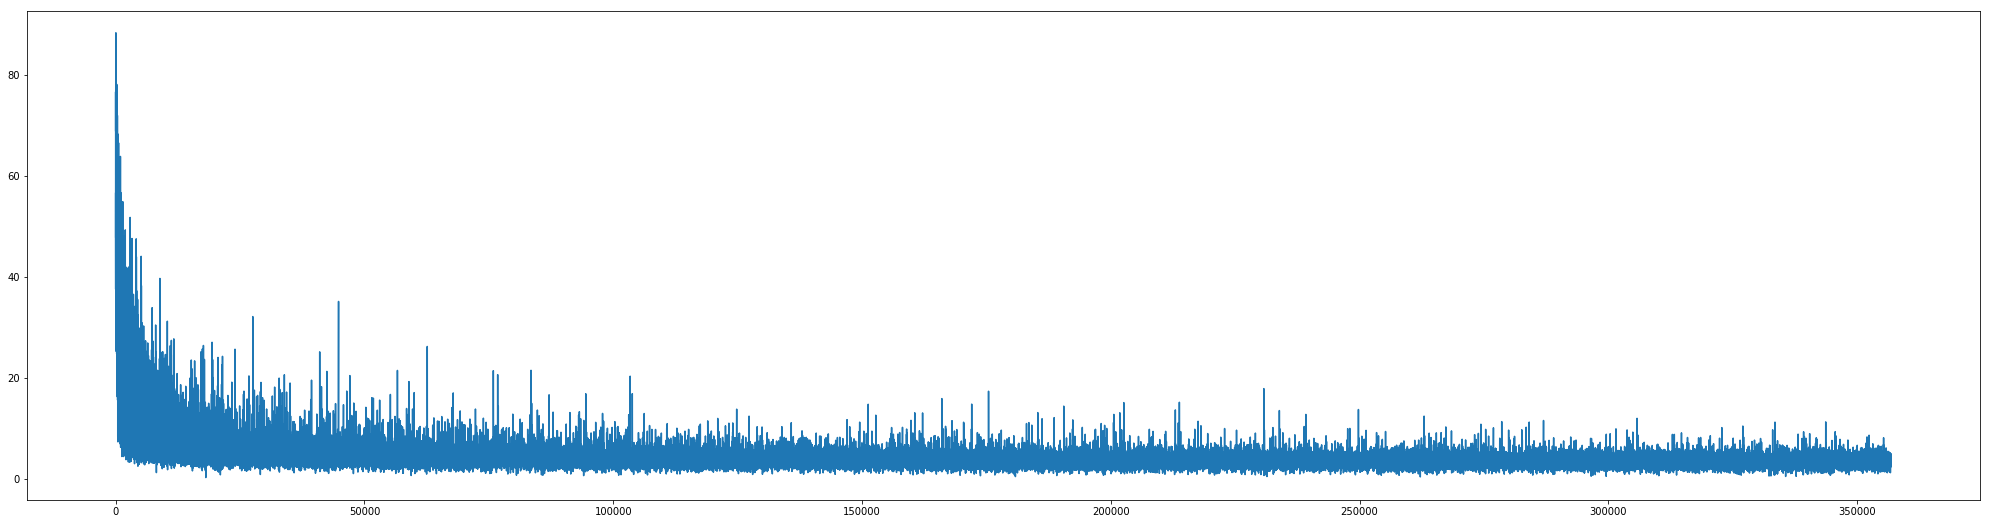

In [281]:
plt.figure(figsize=(35,9))
plt.plot(losses)
print(min(losses))

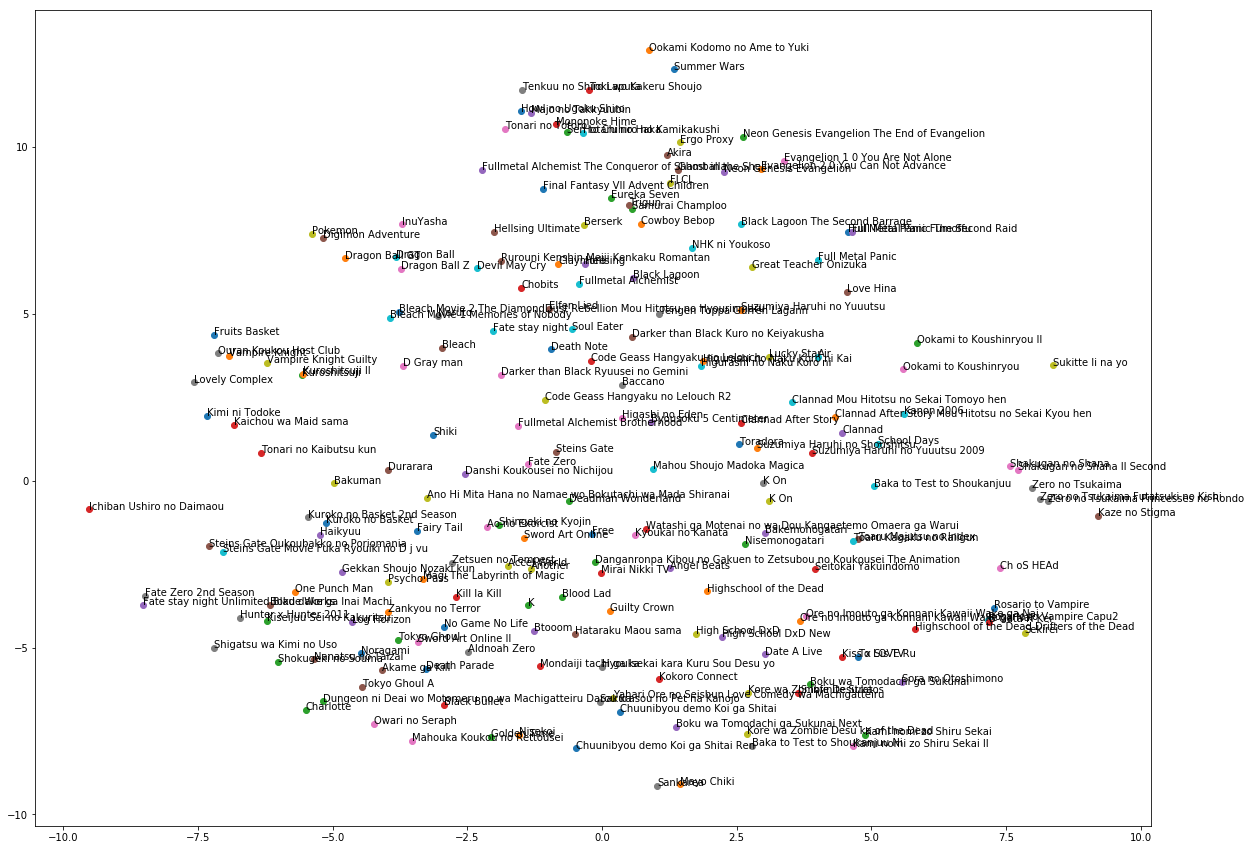

In [284]:
from sklearn.manifold import TSNE

def plot(embeddings, labels):
    plt.figure(figsize=(20, 15)) 
    for i, label in enumerate(labels):
        x, y = embeddings[i, :]
        plt.scatter(x, y)
        plt.annotate(label, xy=(x, y))
              
r = np.arange(1, 200+1)
tsne = TSNE(perplexity=30, n_components=2, init='pca', n_iter=5000, learning_rate=100)
t = tsne.fit_transform(out_embeddings[r, :])
plot(t, [dictionary[i] for i in r])

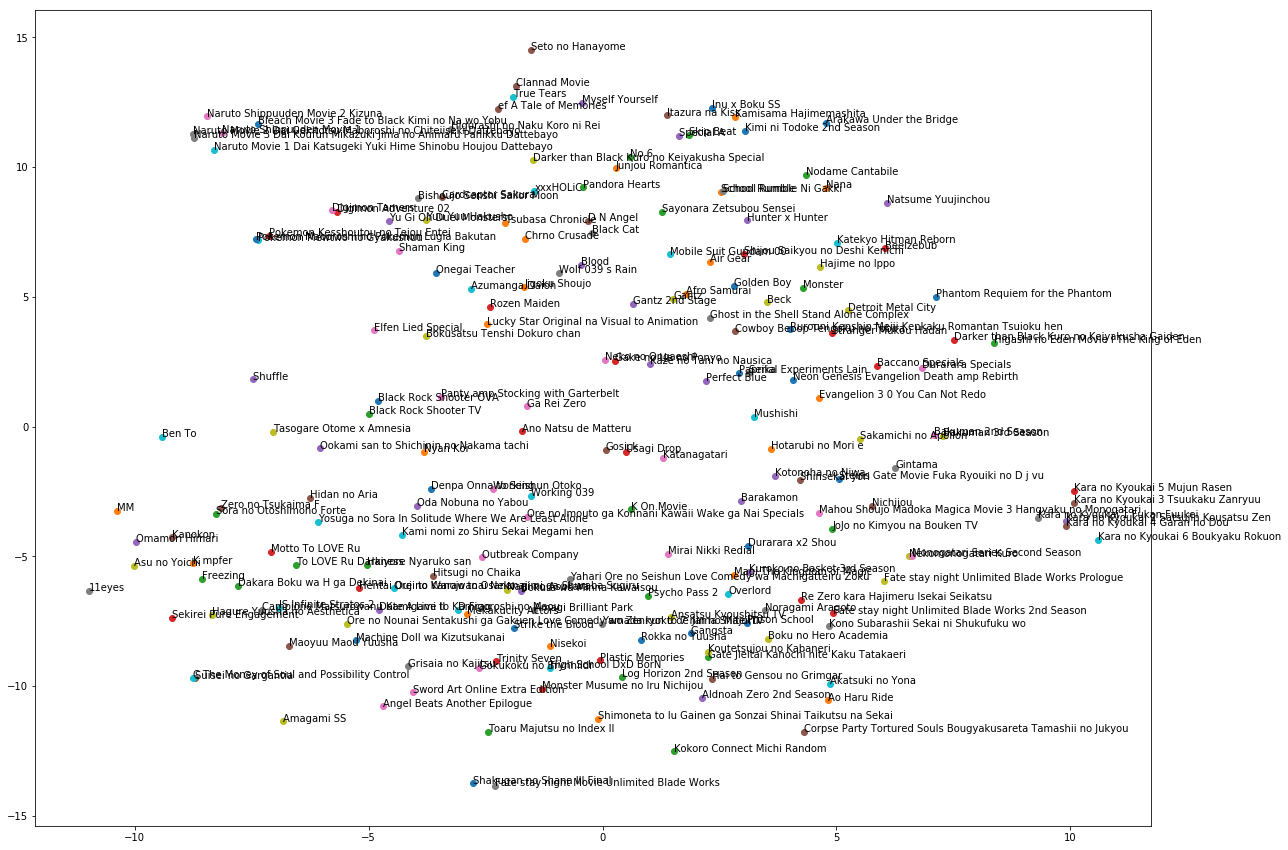

In [285]:
r = np.arange(200, 400+1)
tsne = TSNE(perplexity=30, n_components=2, init='pca', n_iter=5000, learning_rate=100)
t = tsne.fit_transform(out_embeddings[r, :])
plot(t, [dictionary[i] for i in r])

# Build recommender class and evaluate

In [303]:
anime_all = list(set(ratings["name"]))
ani_ids = [reverse_dictionary[s] for s in anime_all]
anime_set = np.array(ani_ids, 'int32')

In [ ]:
# valid_examples = np.array(random.sample(range(1, valid_window+1), valid_size))# valid_e 
vocab_size = len(dictionary)
batch_size = 128
embedding_size = 300  # Dimension of the embedding vector.
val_size =len(anime_set)
lr = 1.2

model = SkipGramModel(vocab_size, anime_set, embedding_dims=embedding_size, 
                      batch_size=batch_size, sample_factor=1., lr=lr, optimizer= tf.train.AdagradOptimizer)

# create the data generator
data_gen = gen_batch(data, batch_size, rel_window_size = .2, shuffle=True)

losses = []

with tf.Session() as sess:
    sess.run(model.init_op())
    print('initialized ...')
    # set so we can watch average loss during training

    for step in tqdm(range(num_steps)):
        batch_inputs, batch_labels = next(data_gen)
        feed_dict = {model.x: batch_inputs, 
                     model.y: batch_labels}
        
        _, loss_ = sess.run([model.optimize, model.loss], feed_dict=feed_dict)
        losses.append(loss_) # for plotting
        
    #sim = model.similarity.eval()
    #for i in range(len(ani_ids)):
    #   show_n_similar(model.val_data[i], sim[i], k=5)
    
    out_embeddings = model.normalized_embeddings.eval()

# Meta Anime2vec ??? Incoming 

In [6]:
"""
users_buckets = {}

for col in ["year", "type", "genre", "episodes", "members"] :
    ratings[col] = ratings[col].astype("category").cat.codes
    
for anime_id in ratings["anime_id"].unique() : 
    meta = ratings[(ratings["anime_id"] == anime_id) & ratings[ "genre"]]
    users_buckets[anime_id] =  ' '.join(meta["user_id"].astype("str"))

del meta
"""